In [3]:
import numpy as np
from get_data import get_data

df = get_data('pups')

x_min = min(df['x'])
x_max = max(df['x'])
from math import pi
df['x_trans'] = ( df['x'] - x_min)/(x_max-x_min)* pi

from math import cos
from math import sqrt

num_rows = len(df.index)


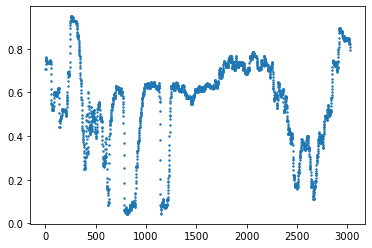

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df['x'],df['y'],s=2)
plt.savefig(f'../Resources/pupslice.png')

plt.show()

1
The condition number under the 2-norm is 1.0
The error is11.4
2
The condition number under the 2-norm is 1.0
The error is11.4
4
The condition number under the 2-norm is 1.0
The error is10.4
9
The condition number under the 2-norm is 1.0
The error is7.9
20
The condition number under the 2-norm is 1.0
The error is5.8
41
The condition number under the 2-norm is 1.0
The error is3.0
87
The condition number under the 2-norm is 1.0
The error is1.9
183
The condition number under the 2-norm is 1.0
The error is1.1
386
The condition number under the 2-norm is 1.1
The error is0.5
813
The condition number under the 2-norm is 1.1
The error is0.1


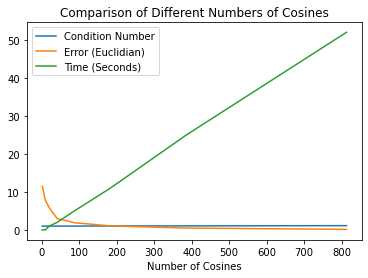

In [5]:
import datetime
log_xs = np.around(np.logspace(0,2.91,10))
from numpy.linalg import cond

conds = []
errors = []
times = []

for num_weights in log_xs:
    
    t1 = datetime.datetime.now()
    
    # num_weights = 850
    num_weights = int(num_weights)

    df['cos0'] = df['x_trans'].apply(lambda x: cos(0*x) / sqrt(num_rows))

    for i in range(1,num_weights):
        df[f'cos{i}'] = df['x_trans'].apply(lambda x: sqrt(2)*cos(i*x) / sqrt(num_rows))

    A = df[[f"cos{x}" for x in range(0,num_weights)]].values
    b = df['y'].values

    w = np.linalg.solve(np.transpose(A) @ A, np.transpose(A) @ b)

    def f(row):
        return sum([row[f'cos{x}'] * w[x] for x in range(0,num_weights)])

    df['pred'] = df.apply(f, axis=1)
    
    df['error'] = (df['pred'] - df['y']) ** 2
    
    error = sum(df['error']) ** (1/2)

    c_num = cond(A)
    
    t2 = datetime.datetime.now()

    print(num_weights)
    print(f"The condition number under the 2-norm is {round(c_num,1)}")
    print(f"The error is{round(error,1)}")
    conds.append(c_num)
    errors.append(error)
    times.append((t2-t1).seconds)

import matplotlib.pyplot as plt
plt.plot(log_xs,conds,label='Condition Number')
plt.plot(log_xs,errors,label='Error (Euclidian)')
plt.plot(log_xs,times,label='Time (Seconds)')
plt.legend()
plt.xlabel('Number of Cosines')
plt.title('Comparison of Different Numbers of Cosines')
plt.savefig(f'../Resources/CosineInfo.png')

plt.show()

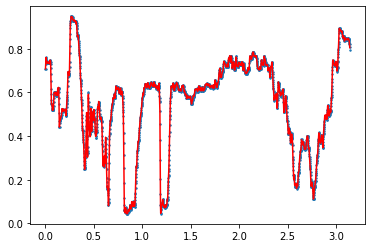

In [6]:
import matplotlib.pyplot as plt


plt.plot(df['x_trans'],df['pred'], c= "r")
plt.scatter(df['x_trans'],df['y'],s=2)
plt.savefig(f'../Resources/pupRegression.png')

plt.show()

Text(0.5, 1.0, 'Weights of cosines in the 813 case')

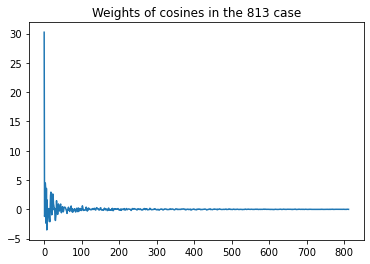

In [7]:
plt.plot(w)
plt.title('Weights of cosines in the 813 case')

(-2.0, 2.0)

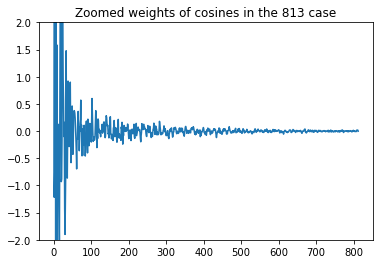

In [8]:
plt.plot(w)
plt.title('Zoomed weights of cosines in the 813 case')
plt.ylim(-2,2)

# Decision Trees

10
1.2248346638321792


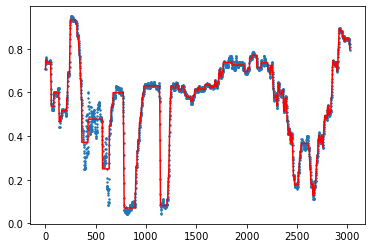

In [23]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=2,ccp_alpha=100)

for max_depth in [10]: #np.around(np.logspace(0,1.4,10)):

    regr_1 = DecisionTreeRegressor(max_depth=max_depth)
    
    regr_1.fit(df['x'].values.reshape(-1, 1), df['y'])
    
    df['dec_tree'] = regr_1.predict(df['x'].values.reshape(-1, 1))

    print(max_depth)
    print(sum((df['dec_tree'] - df['y']) ** 2) ** (1/2))

plt.plot(df['x'],df['dec_tree'], c= "r")
plt.scatter(df['x'],df['y'],s=2)
plt.show()

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

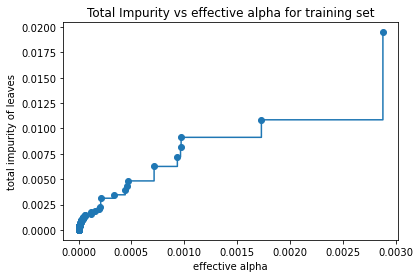

In [25]:
clf = DecisionTreeRegressor(random_state=0)
path = clf.cost_complexity_pruning_path(df['x'].values.reshape(-1, 1), df['y'])
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [26]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(df['x'].values.reshape(-1, 1), df['y'])
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0059471689621953885


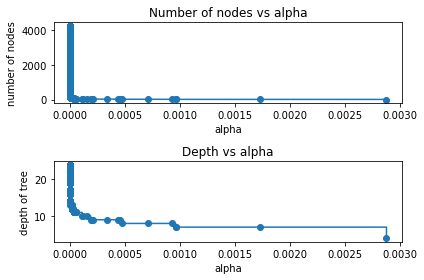

In [27]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

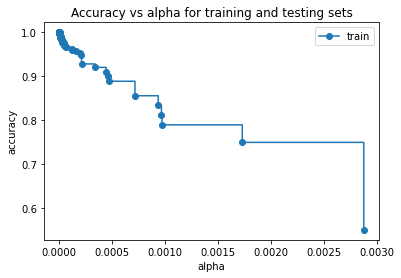

In [28]:
train_scores = [clf.score(df['x'].values.reshape(-1, 1), df['y']) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.legend()
plt.show()

0.7578185763727112


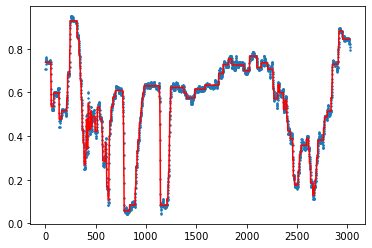

In [42]:
ccp_alphas[-100]
new_clf = clfs[-100]
print(sum((new_clf.predict(df['x'].values.reshape(-1, 1)) - df['y']) ** 2) ** (1/2))
plt.plot(df['x'],new_clf.predict(df['x'].values.reshape(-1, 1)), c= "r")
plt.scatter(df['x'],df['y'],s=2)
plt.show()

# Plotting the Decision Tree

[Text(279.6253829956055, 211.04470588235293, 'X[0] <= 2849.5\nmse = 0.043\nsamples = 3024\nvalue = 0.55'),
 Text(232.29764099121095, 198.25411764705882, 'X[0] <= 2406.5\nmse = 0.041\nsamples = 2849\nvalue = 0.534'),
 Text(163.14450073242188, 185.4635294117647, 'X[0] <= 1242.5\nmse = 0.038\nsamples = 2406\nvalue = 0.569'),
 Text(97.09486083984375, 172.6729411764706, 'X[0] <= 361.5\nmse = 0.055\nsamples = 1242\nvalue = 0.482'),
 Text(22.88671875, 159.88235294117646, 'X[0] <= 241.5\nmse = 0.024\nsamples = 361\nvalue = 0.685'),
 Text(10.4625, 147.09176470588235, 'X[0] <= 56.5\nmse = 0.009\nsamples = 241\nvalue = 0.6'),
 Text(5.23125, 134.30117647058825, 'X[0] <= 54.5\nmse = 0.0\nsamples = 56\nvalue = 0.736'),
 Text(2.615625, 121.51058823529411, 'mse = 0.0\nsamples = 54\nvalue = 0.738'),
 Text(7.846875000000001, 121.51058823529411, 'mse = 0.0\nsamples = 2\nvalue = 0.667'),
 Text(15.693750000000001, 134.30117647058825, 'X[0] <= 220.5\nmse = 0.004\nsamples = 185\nvalue = 0.559'),
 Text(13.078

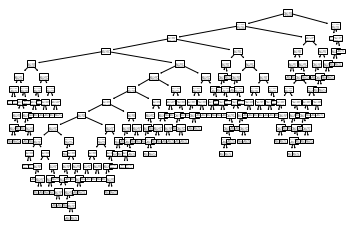

In [43]:
from sklearn import tree
tree.plot_tree(new_clf)